## Dataset Iris

#### 1. Carga de datos y librerías

Este cuaderno demuestra el flujo completo sobre el conjunto Iris usando únicamente numpy, pandas y matplotlib, además de las clases propias en src/.

En esta sección:
- Añadimos la ruta al paquete local src/.
- Cargamos Iris.csv desde ../data/.
- Separamos atributos y etiquetas; convertimos etiquetas de texto a índices 0..K-1 y luego a one-hot.
- Estandarizamos las columnas de X (media 0, desviación 1) para estabilizar el entrenamiento.

La estandarización aquí se calcula sobre todo el conjunto para simplificar el ejemplo de Iris.

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.NeuralNetwork import NeuralNetwork
from src.OptimizerAdam import OptimizerAdam
from src.Trainer import Trainer
from src.Losses import categorical_cross_entropy
from src.HyperparameterTuner import HyperparameterTuner

df = pd.read_csv("../data/Iris.csv")
X = df.iloc[:, 1:-1].values
y_labels = df.iloc[:, -1].values
unique_classes = np.unique(y_labels)
y = np.array([np.where(unique_classes == label)[0][0] for label in y_labels])
Y = np.zeros((y.size, len(unique_classes)))
Y[np.arange(y.size), y] = 1

X = (X - X.mean(axis=0)) / X.std(axis=0)

####  2. División en Train/Test/Val


Se realiza una partición con semilla fija para reproducibilidad:
- 80 % entrenamiento, 10 % validación, 10 % prueba.
- Se barajan los índices y se trocean por tamaños.

El objetivo es disponer de un conjunto de validación para monitorizar early stopping y evitar sobreajuste; y un conjunto test totalmente ciego para el resultado final.

In [14]:
np.random.seed(42)
indices = np.random.permutation(X.shape[0])

train_size = int(0.8 * X.shape[0])
val_size = int(0.1 * X.shape[0])

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

print(f"Datos cargados: {X.shape[0]} muestras, {X.shape[1]} atributos, {Y.shape[1]} clases")

Datos cargados: 150 muestras, 4 atributos, 3 clases


#### 3. Búsqueda de hiperparámetros

Usamos HyperparameterTuner para explorar combinaciones razonables de:
- Tasa de aprendizaje (lr), batch size, regularización L2, capas ocultas, activación, parámetros de Adam y dropout.
- Métricas de selección: mejor val_acc y, a empate, menor val_loss.
- Paciencia de early stopping para cortar entrenamientos que dejan de mejorar.

Este grid es acotado y pequeño para Iris, con fines demostrativos. El cuaderno imprime un Top-5 de configuraciones por validación.

In [15]:
tuner = HyperparameterTuner(X_train, Y_train, X_val, Y_val)
for e in [100, 150, 200]:
    results = tuner.search(
        lr_list=[0.001, 0.005, 0.01, 0.1],
        batch_sizes=[16, 32],
        regs=[0.0001, 0.001],
        hidden_layers=[[8], [12], [6]],
        activations=["relu", "tanh"],
        betas=[(0.9, 0.999), (0.99, 0.95)],
        dropout_rates=[0.0, 0.2, 0.5],
        epochs=e,
        patience=10,
        decay=0.95,
        seed=42
    )
df_results = pd.DataFrame(results)
best = df_results.sort_values(by=["best_val_acc", "best_val_loss"], ascending=[False, True]).head(5)
best.iloc[[0]]


 [1/192] lr=0.001, batch=16, λ=0.0001, layers=[8], act=relu, β=(0.9,0.999)
Decaimiento del learning rate: nuevo lr = 0.000950
Decaimiento del learning rate: nuevo lr = 0.000902
Decaimiento del learning rate: nuevo lr = 0.000857
Decaimiento del learning rate: nuevo lr = 0.000815
Decaimiento del learning rate: nuevo lr = 0.000774

 [2/192] lr=0.001, batch=16, λ=0.0001, layers=[8], act=relu, β=(0.9,0.999)
Decaimiento del learning rate: nuevo lr = 0.000950
Decaimiento del learning rate: nuevo lr = 0.000902
Decaimiento del learning rate: nuevo lr = 0.000857
Decaimiento del learning rate: nuevo lr = 0.000815
Decaimiento del learning rate: nuevo lr = 0.000774

 [3/192] lr=0.001, batch=16, λ=0.0001, layers=[8], act=relu, β=(0.9,0.999)
Decaimiento del learning rate: nuevo lr = 0.000950
Decaimiento del learning rate: nuevo lr = 0.000902
Decaimiento del learning rate: nuevo lr = 0.000857
Decaimiento del learning rate: nuevo lr = 0.000815
Decaimiento del learning rate: nuevo lr = 0.000774

 [4/19

,id,lr,batch_size,lambda_reg,hidden_layers,activation,beta1,beta2,dropout_rate,best_val_acc,best_val_loss
0,484,0.1,16,0.001,[12],relu,0.99,0.95,0.0,1.0,0.000031


#### 4. Modelo, optimizador y entrenamiento

A partir del grid (o fijando manualmente), definimos:
- Arquitectura MLP [4, 12, 3]: 4 entradas (mediciones), una capa oculta de 12 neuronas y 3 salidas (clases).
- Activación ReLU, salida softmax, pérdida CCE, inicialización Xavier, L2 y dropout (aquí desactivado).
- Adam con hiperparámetros seleccionados y decaimiento del learning rate en el Trainer.
- Entrenamiento con mini-lotes y registro de historial (hist["train_loss"], hist["val_loss"], hist["train_acc"], hist["val_acc"]).

El criterio de parada es el early stopping con paciencia 10. Se conserva el mejor checkpoint por validación.

In [ ]:
model = NeuralNetwork(layers=[4, 12, 3], activation='relu', output_activation='softmax', loss='cce', seed=42, init='xavier', lambda_reg=0.001, dropout_rate=0.0)
optimizer = OptimizerAdam(lr=0.1, beta1=0.99, beta2=0.95, eps=1e-8)
trainer = Trainer(model, optimizer, categorical_cross_entropy, patience=10, decay=0.9)

losses_train = []
losses_val = []
accuracy_train = []
accuracy_val = []

hist = trainer.train(X_train, Y_train, X_val, Y_val, epochs=180, batch_size=16)

Época 001 | Train Loss: 3.6995 | Train Acc: 68.75% | Val Loss: 4.5504 | Val Acc: 73.33%
Época 002 | Train Loss: 3.0839 | Train Acc: 80.47% | Val Loss: 2.7704 | Val Acc: 73.33%
Época 003 | Train Loss: 3.3292 | Train Acc: 67.19% | Val Loss: 4.0750 | Val Acc: 53.33%
Época 004 | Train Loss: 1.9237 | Train Acc: 75.78% | Val Loss: 2.0156 | Val Acc: 73.33%
Época 005 | Train Loss: 2.1335 | Train Acc: 78.12% | Val Loss: 1.3663 | Val Acc: 80.00%
Época 006 | Train Loss: 1.9139 | Train Acc: 78.91% | Val Loss: 0.1214 | Val Acc: 86.67%
Época 007 | Train Loss: 1.7231 | Train Acc: 79.69% | Val Loss: 0.0480 | Val Acc: 100.00%
Época 008 | Train Loss: 1.2458 | Train Acc: 86.72% | Val Loss: 0.0131 | Val Acc: 100.00%
Época 009 | Train Loss: 0.7779 | Train Acc: 86.72% | Val Loss: 0.0038 | Val Acc: 100.00%
Época 010 | Train Loss: 0.5325 | Train Acc: 87.50% | Val Loss: 0.0017 | Val Acc: 100.00%
Época 011 | Train Loss: 0.3403 | Train Acc: 92.97% | Val Loss: 0.1372 | Val Acc: 93.33%
Época 012 | Train Loss: 0.35

#### 5. Evaluación y visualización

En primer lugar, inferimos sobre el conjunto de prueba y calculamos accuracy. En sehundo lugar, dibujamos la evolución de la pérdida y de la precisión (train/val) por época para analizar convergencia y posibles brechas. Finalmente, mostramos una matriz de confusión simple para localizar errores por clase (típicamente, confusiones entre versicolor y virginica).

In [17]:
A_pred, _ = model.forward(X_test)
y_pred = np.argmax(A_pred.T, axis=1)
y_true = np.argmax(Y_test, axis=1)
accuracy_test = np.mean(y_pred == y_true)
print(f"Precisión final en test: {accuracy_test*100:.2f}%")

Precisión final en test: 93.33%


5.1 Gráfica evolución de las pérdidas

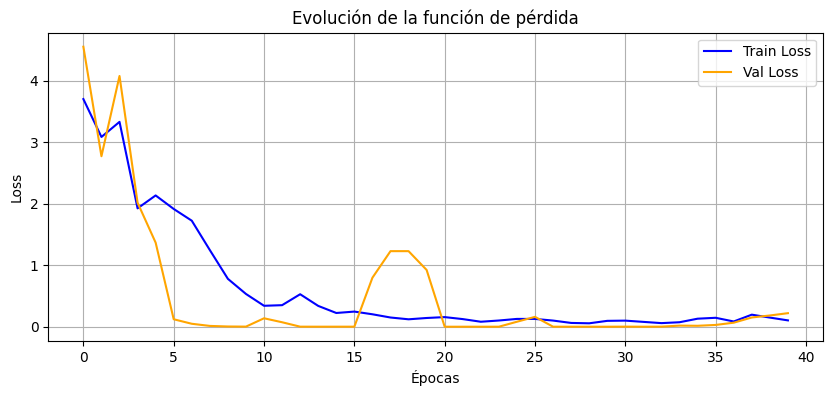

In [18]:
plt.figure(figsize=(10,4))
plt.plot(hist["train_loss"], label="Train Loss", color='blue')
plt.plot(hist["val_loss"], label="Val Loss", color='orange')
plt.title("Evolución de la función de pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


5.2 Gráfica de la evolución de la precisión

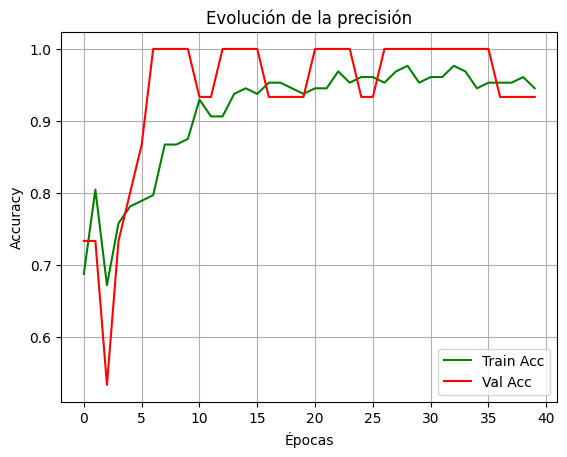

In [19]:

plt.plot(hist["train_acc"], label="Train Acc", color='green')
plt.plot(hist["val_acc"], label="Val Acc", color='red')
plt.title("Evolución de la precisión")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

5.3 Matriz de confusión

In [20]:
def confusion_matrix_simple(y_true, y_pred, labels=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    n = len(labels)
    matrix = np.zeros((n, n), dtype=int)
    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            matrix[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))
    print("Matriz de confusión:")
    print("   Predicciones →")
    print("Reales ↓")
    for i, true_label in enumerate(labels):
        print(f"{true_label:>8} |", " ".join(f"{x:4d}" for x in matrix[i]))
    return matrix

confusion_matrix_simple(y_true, y_pred)


Matriz de confusión:
   Predicciones →
Reales ↓
       0 |    2    0    0
       1 |    0    6    0
       2 |    0    1    6


array([[2, 0, 0],
       [0, 6, 0],
       [0, 1, 6]])